In [1]:
import pandas as pd
import missingno as msno
import seaborn as sns
import datetime as dt
from datetime import datetime
df_migration_pre = pd.read_csv("dataset_migration.csv")
df_hdi_pre = pd.read_csv("HDI_Index.csv")

In [2]:
def dateto_ordinal(df,date_column):
    #Función para convertir fecha a tipo ordinal
    df['Fecha_Numerico']=df[date_column].map(dt.datetime.toordinal)
    return df

def country_code_num(df):
    #Funcion para crear diccionario codigo pais y "label_encoder"
    country_code = df["Country Code"].unique()
    country_code = country_code.tolist()
    country_code_c = {}
    keys = country_code
    values = range(1, len(keys)+1)
    for key, value in zip(keys, values):
        country_code_c[key] = value
    #Add new column Country_code_num
    df["country_code_c"] = df["Country Code"].map(country_code_c)
    #Funcion para crear diccionario id pais y "label_encoder"
    num_country_code = {v: k for k, v in country_code_c.items()}
    return df

def clearna (df):
    #Funcion para eliminar registros nulos
    df.dropna(inplace=True)
    return df

def dropcolumns_for_ml(df):
    #Funcion para dejar columnas de tipo float para el modelo de ml
    df = df.drop(["Country Code","Year","Unemployment Advanced Education (%)","Unemployment Intermediate Education (%)", "Unemployment Basic Education (%)","Labor Taxes and Contributions (%)","Social Protection and Labor Programs (%)","Poverty Rate (%)"],axis=1)
    return df

def dropcolumns(df):
    #Funcion para eliminar columnas
    df = df.drop(["Unemployment Advanced Education (%)","Unemployment Intermediate Education (%)", "Unemployment Basic Education (%)","Labor Taxes and Contributions (%)","Social Protection and Labor Programs (%)","Poverty Rate (%)"],axis=1)
    return df

def preprodata(df_migration,df_hdi):
    #Funcion para preprocesamiento de datos
    #unir dataframes
    df = df_migration.merge(df_hdi, how="left", on=["Country Name", "Country Code", "Year"])
    #eliminar columnas redundanes o que no tienen importancia en el modelo
    df.drop(["Unnamed: 0_x","Unnamed: 0_y"], axis= 1, inplace=True)
    df.drop("PIB Growth (%)", axis= 1, inplace=True)
    #Convertir year as date
    df["Year"] = pd.to_datetime(df["Year"].astype(str),format= "%Y")
    df= dateto_ordinal(df,"Year")
    df = country_code_num(df)
    df_ml = df
    df = dropcolumns(df)
    df = clearna(df)
    df_ml = dropcolumns_for_ml(df_ml)
    df_ml = clearna(df_ml)
    return df_ml , df

def country_reduce(df,list_country):
    mask = df["Country Name"].isin(list_country)
    df_filtered = df[mask]
    return df_filtered

#Función para convertir año a número ordinal
def convert_year_to_ordinal(year_input):
    year_num = datetime.strptime(year_input,'%Y').toordinal()
    return year_num

def year_filter(df,year_str):
    year_num = convert_year_to_ordinal(year_str)
    mask = df["Fecha_Numerico"] == year_num 
    df_filtered = df[mask]
    return df_filtered

In [3]:
#Lista de paises para el modelo ML paises receptores y emisores en conjunto
country_list =['Afganistán','Francia','China','Canadá','India','España',
                'México','Alemania','Venezuela','Italia','Pakistán','Estados Unidos',
               'Ucrania','Arabia Saudita','Bangladesh','Australia','República Árabe Siria',	
               'Reino Unido','Yemen, Rep. del','Federación de Rusia']

#Ejecución función de preprocesamiento
dfm_total_ml, dfm_total = preprodata(df_migration_pre,df_hdi_pre)
dfm_ml = country_reduce(dfm_total_ml,country_list)
dfm_total = country_reduce(dfm_total,country_list)

In [4]:
print(dfm_ml["Country Name"].value_counts())
print(dfm_ml.info())
print(dfm_total.info())

Australia                21
Italia                   21
Estados Unidos           21
Ucrania                  21
República Árabe Siria    21
Arabia Saudita           21
Federación de Rusia      21
Pakistán                 21
Bangladesh               21
México                   21
India                    21
Reino Unido              21
Francia                  21
España                   21
Alemania                 21
China                    21
Canadá                   21
Yemen, Rep. del          19
Afganistán               19
Venezuela                15
Name: Country Name, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 410 entries, 10 to 4543
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country Name             410 non-null    object 
 1   Net Migration            410 non-null    float64
 2   PIB per Capita           410 non-null    float64
 3   Total Unemployment (%)   4

In [15]:
#Función para ejecutar modelo no supervisado
def func_scaler(df):
    X_in = df.drop(["Fecha_Numerico","Country Name"],axis=1).values
    #Escalar X
    #Escalado de todos los features Min_Max scaler
    # Import MinMaxScaler
    from sklearn.preprocessing import MinMaxScaler
    # Instantiate MinMaxScaler
    MM_scaler = MinMaxScaler()
    # Fit MM_scaler to the data
    MM_scaler.fit(X_in)
    #Escalado de todos los features Min_Max scaler
    X = MM_scaler.transform(X_in)
    return X

def func_clusters(X_in,eps_in,samples_in):
    from sklearn.cluster import DBSCAN
    # Especificamos los valores de los hiperparámetros de los tres modelos.
    db = DBSCAN(eps=eps_in, min_samples=samples_in)
    db.fit(X_in)
    # Consultamos las etiquetas del primer modelo
    labels = db.labels_
    # Número de clusters en las etiquetas, ignorando el ruido en caso que esté presente.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    # Consultamos para el primer modelo
    print('Número estimado de clusters: %d' % n_clusters)
    print('Número estimado de puntos de ruido: %d' % n_noise)
    #centroids = kmeans.cluster_centers_
    #labels = kmeans.labels_
    return labels, n_clusters, db

X = func_scaler(dfm_ml)
labels, n_clusters, db = func_clusters(X,eps_in = 0.25,samples_in=10)

Número estimado de clusters: 6
Número estimado de puntos de ruido: 5


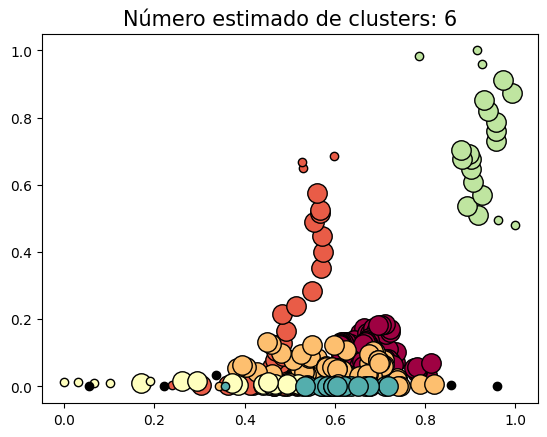

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_DBSCAN(X1,labels_1,db_1,n_clusters_1):
    # Creamos una máscara
    core_samples_mask_1 = np.zeros_like(db_1.labels_, dtype=bool)
    core_samples_mask_1[db_1.core_sample_indices_] = True
    # Plot result

    
    unique_labels = set(labels_1)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]

        class_member_mask = (labels_1 == k)

        xy = X1[class_member_mask & core_samples_mask_1]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X1[class_member_mask & ~core_samples_mask_1]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    plt.title('Número estimado de clusters: %d' % n_clusters_1, fontsize = 15)
    plt.show()
    return

plot_DBSCAN(X,labels,db,n_clusters)

In [7]:
#Add labels to Dataframes
def add_labels(df,labels_in):
    df["labels"] =labels_in
    return df

#Function to show clusters
def func_groupby(df):
    df_group = df.groupby("labels").value_counts().reset_index(name='count')
    print(df.groupby("labels")["Country Name"].value_counts())
    df_group =df_group.drop("count",axis=1)
    return df_group

dfm_ml = add_labels(dfm_ml,labels)
df_group = func_groupby(dfm_ml)
df_group.labels.value_counts()

labels  Country Name         
-1      República Árabe Siria     2
        Afganistán                1
        Arabia Saudita            1
        Pakistán                  1
 0      Alemania                 21
        Australia                21
        Canadá                   21
        España                   21
        Francia                  21
        Italia                   21
        Reino Unido              21
 1      Bangladesh               21
        China                    21
 2      Federación de Rusia      21
        India                    21
        México                   21
        Ucrania                  21
        Arabia Saudita           20
        República Árabe Siria    19
        Yemen, Rep. del          19
        Venezuela                15
 3      Pakistán                 20
 4      Estados Unidos           21
 5      Afganistán               18
Name: Country Name, dtype: int64


C:\Users\julia\AppData\Local\Temp\ipykernel_13788\1450896543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"] =labels_in


 2    157
 0    147
 1     42
 4     21
 3     20
 5     18
-1      5
Name: labels, dtype: int64

Número estimado de clusters: 6
Número estimado de puntos de ruido: 5


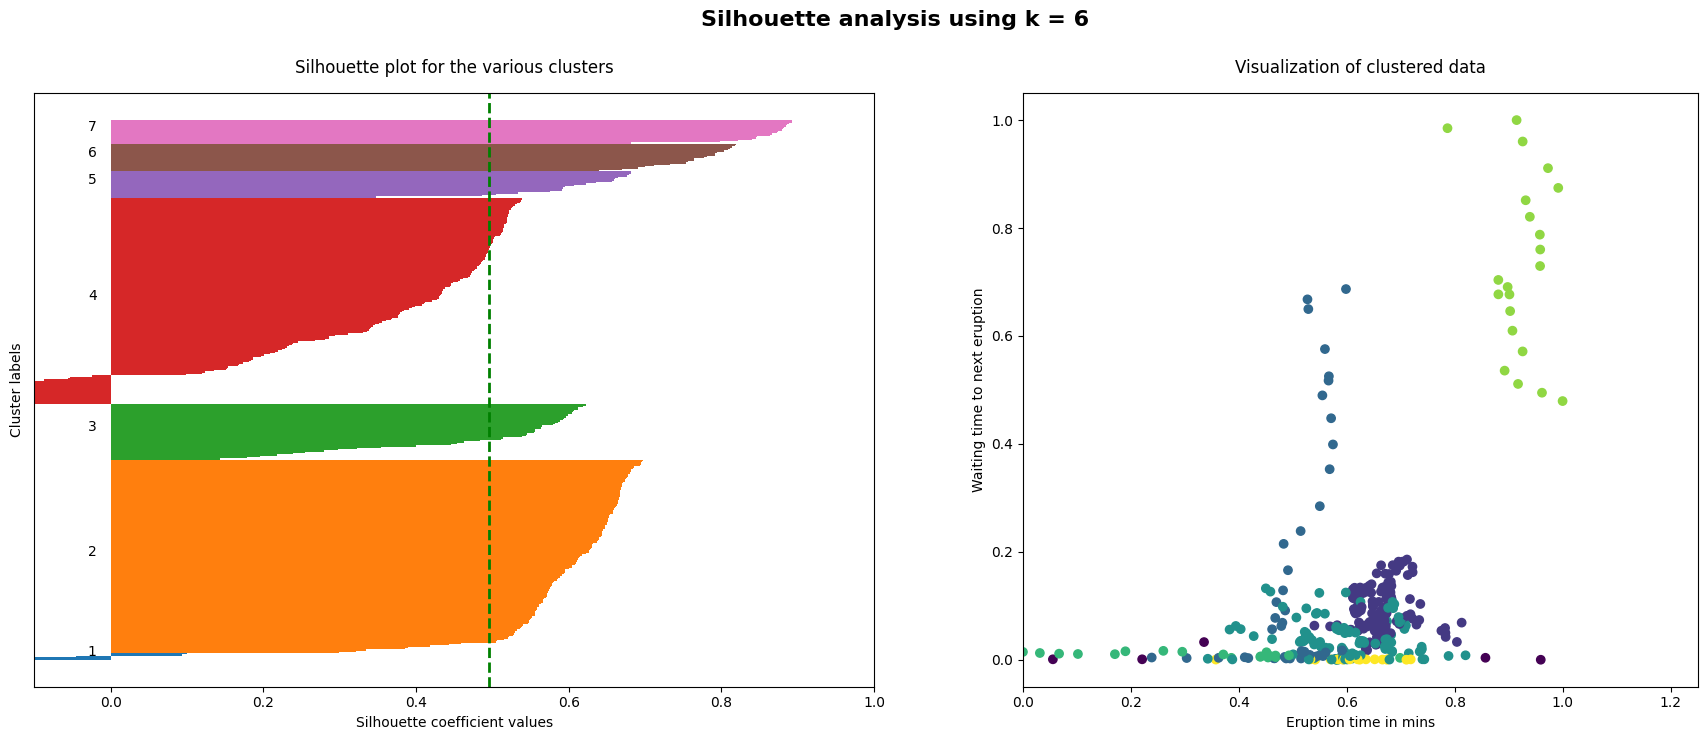

In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
# Ingresamos el Dataset con el que queremos trabajar
X_std = func_scaler(dfm_ml)
#X_std = X1

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

#labels = db.labels_
labels, n_clusters, db = func_clusters(X)

silhouette_vals = silhouette_samples(X_std, labels)

y_ticks = []
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(labels)):
    cluster_silhouette_vals = silhouette_vals[labels == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
    y_lower += len(cluster_silhouette_vals)


avg_score = np.mean(silhouette_vals)
ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
ax1.set_yticks([])
ax1.set_xlim([-0.1, 1])
ax1.set_xlabel('Silhouette coefficient values')
ax1.set_ylabel('Cluster labels')
ax1.set_title('Silhouette plot for the various clusters', y=1.02);


ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels)

ax2.set_xlim([0, 1.25])
ax2.set_xlim([0, 1.25])
ax2.set_xlabel('Eruption time in mins')
ax2.set_ylabel('Waiting time to next eruption')
ax2.set_title('Visualization of clustered data', y=1.02)
ax2.set_aspect('equal')
plt.tight_layout()
plt.suptitle(f'Silhouette analysis using k = {n_clusters}',
             fontsize=16, fontweight='semibold', y=1.05);

In [31]:
#Generación cluster solo para año 2020
#Generando Data Frame filtrado por el último año
dfm_ml_year = year_filter(dfm_ml,"2020")

#Generación de cluster - 6
X_year = func_scaler(dfm_ml_year)
labels_6_2020, n_clusters_2020, db_6_2020  = func_clusters(X_year,eps_in = 0.5,samples_in=1)
dfm_ml_year = add_labels(dfm_ml_year,labels_6_2020)
df_group_6_2020 = func_groupby(dfm_ml_year)
df_group_6_2020.labels.value_counts()
df_group_6_2020.to_csv("df_group_6_2020_db.csv",index=False)

Número estimado de clusters: 8
Número estimado de puntos de ruido: 0
labels  Country Name         
0       Afganistán               1
1       Alemania                 1
        Australia                1
        Canadá                   1
        Francia                  1
        Italia                   1
        Reino Unido              1
2       Bangladesh               1
        Federación de Rusia      1
        India                    1
        México                   1
        República Árabe Siria    1
        Ucrania                  1
3       China                    1
4       España                   1
5       Pakistán                 1
6       Arabia Saudita           1
7       Estados Unidos           1
Name: Country Name, dtype: int64


C:\Users\julia\AppData\Local\Temp\ipykernel_13788\1450896543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"] =labels_in
